In [1]:
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [2]:
grid_r, grid_c = 5, 5
state_num = grid_r * grid_c
action_num = 5
r_other_step = 0.0
r_forbidden = -1.0
r_target = 1.0
r_boundary = -1.0
gamma=0.9
dr=np.array([-1,0,1,0,0])
dc=np.array([0,1,0,-1,0])
episode_num=500
step_num=500
alpha=0.0005

reward = np.array([
    [r_other_step, r_other_step, r_other_step, r_other_step, r_other_step],
    [r_other_step, r_forbidden, r_forbidden, r_other_step, r_other_step],
    [r_other_step, r_other_step, r_forbidden, r_other_step, r_other_step],
    [r_other_step, r_forbidden, r_target, r_forbidden, r_other_step],
    [r_other_step, r_forbidden, r_other_step, r_other_step, r_other_step]
])
policy_b = np.ones((state_num, action_num)) * 0.2  # behavior policy

v_target=np.array([
    [-3.8463, -3.8138, -3.6442, -3.1209, -3.2350],
    [-3.7936, -3.8473, -3.8004, -3.1063, -2.9241],
    [-3.5724, -3.8965, -3.3817, -3.1944, -2.9444],
    [-3.9008, -3.6159, -3.4031, -2.8976, -3.2393],
    [-4.4589, -4.1608, -3.3858, -3.3634, -3.4532]
])

In [3]:
def s2grid(s):
    return s//grid_c,s%grid_c

def grid2s(r,c):
    return r*grid_c+c

def gen_action(s,policy_b):
    prob=policy_b[s]
    rand_num = random.random()
    cumulative_prob = np.cumsum(prob)
    selected_action = np.argmax(rand_num < cumulative_prob)
    return selected_action

def gen_sample(reward,policy_b,sample_num):
    s=random.randint(0,state_num-1)  # init s
    a=gen_action(s,policy_b)
    buffer=[]

    next_s,next_action,cur_reward=-1,-1,-1
    for _ in range(sample_num):
        r,c=s2grid(s)
        next_r=r+dr[a]
        next_c=c+dc[a]
        if(next_r<0 or next_r>=grid_r or next_c<0 or next_c>=grid_c):#撞墙
            next_s=s
            cur_reward=r_boundary
        else:
            next_s=grid2s(next_r,next_c)
            cur_reward=reward[next_r,next_c]
        
        buffer.append((s,cur_reward,next_s))
        s=next_s
        a=gen_action(s,policy_b)
    
    return np.array(buffer)

In [4]:
dim=10
type=0
def fourier(s,dim):
    y,x=s2grid(s)
    y,x=y/4,x/4
    if dim==4:
        return np.cos(np.pi*np.array([[0,x,y,x+y]])).T
    if dim==9:
        return np.cos(np.pi*np.array([[0,x,2*x,y,x+y,2*x+y,2*y,x+2*y,2*x+2*y]])).T
    if dim==16:
        return np.cos(np.pi*np.array([[0,x,2*x,y,x+y,2*x+y,2*y,x+2*y,2*x+2*y,3*x,3*x+y,3*x+2*y,3*y,3*y+x,3*y+2*x,3*x+3*y]])).T
def polynomial(s,dim):
    y,x=s2grid(s)
    y,x=y/4,x/4
    if dim==3:
        return np.array([[1,x,y]]).T
    if dim==6:
        return np.array([[1,x,y,x**2,y**2,x*y]]).T
    if dim==10:
        # print(1)
        return np.array([[1,x,y,x**2,y**2,x*y,x**3,y**3,(x**2)*y,(y**2)*x]]).T
        
def get_polynomial(s,dim):#返回的是列向量
    if type==0:
        return polynomial(s,dim)
    elif type==1:
        return fourier(s,dim)


def get_w(dim):
    return np.zeros((dim,1))

def get_state_value_error(w,dim):
    v=np.zeros((grid_r,grid_c))
    for y in range(grid_r):
        for x in range(grid_c):
            s=grid2s(y,x)
            v[y,x]=(get_polynomial(s,dim).T@w).item()
    return np.sqrt(np.mean((v-v_target)**2))

w=get_w(dim)
rmse_list=[]
for _ in range(episode_num):
    road=gen_sample(reward=reward,policy_b=policy_b,sample_num=step_num)
    for s,r,s2 in road:
        temp=get_polynomial(s,dim)
        w=w+alpha*(r+gamma*(get_polynomial(s2,dim).T@w)-(temp.T@w))*temp
    rmse_list.append(get_state_value_error(w,dim))

In [5]:
def get_result(w,dim):
    v=np.zeros((grid_r,grid_c))
    for y in range(grid_r):
        for x in range(grid_c):
            s=grid2s(y,x)
            v[y,x]=(get_polynomial(s,dim).T@w).item()
    return v

In [6]:
v=get_result(w,dim)
v

array([[-3.47810259, -3.47431356, -3.43745044, -3.35915918, -3.23108575],
       [-3.58781251, -3.54910391, -3.47064477, -3.34408105, -3.16105872],
       [-3.74621865, -3.66263074, -3.53261585, -3.34781996, -3.09988901],
       [-3.97636692, -3.83793998, -3.64640963, -3.39342183, -3.07062253],
       [-4.30130325, -4.09807756, -3.83507202, -3.50393258, -3.09630522]])

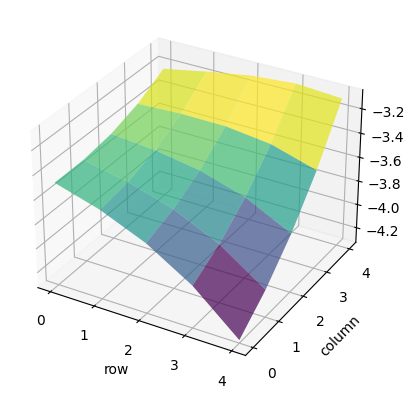

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
m, n = v.shape

# 生成x坐标数组，假设列索引对应的x坐标均匀分布，这里以简单的线性间隔为例
x = np.arange(0, n)

# 生成y坐标数组，同理假设行索引对应的y坐标均匀分布
y = np.arange(0, m)

# 使用meshgrid生成用于绘图的二维坐标网格
X, Y = np.meshgrid(x, y)
# 创建图形对象
fig = plt.figure()
# 添加3D子图
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, v, cmap='viridis', alpha = 0.7)
# 设置坐标轴标签
ax.set_xlabel('row')
ax.set_ylabel('column')
# ax.set_zlabel('')
# min_z=-5
# max_z=-2
# ax.set_zticks(np.arange(min_z,max_z))

plt.show()

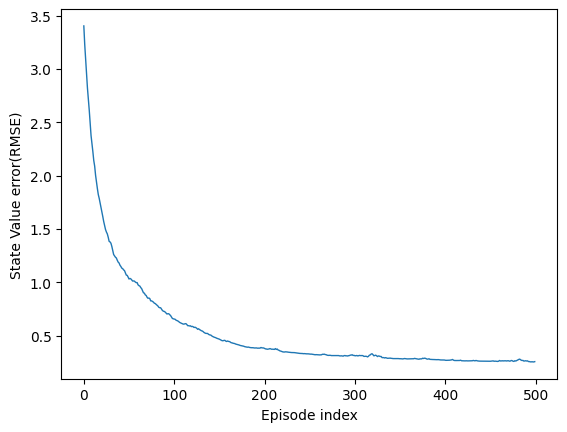

In [8]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontManager

x_axis=[i for i in range(episode_num)]
# plt.plot(x_axis, loss_list)
plt.plot(x_axis, rmse_list,linewidth = 1)
plt.xlabel('Episode index')
plt.ylabel('State Value error(RMSE)')
plt.show()

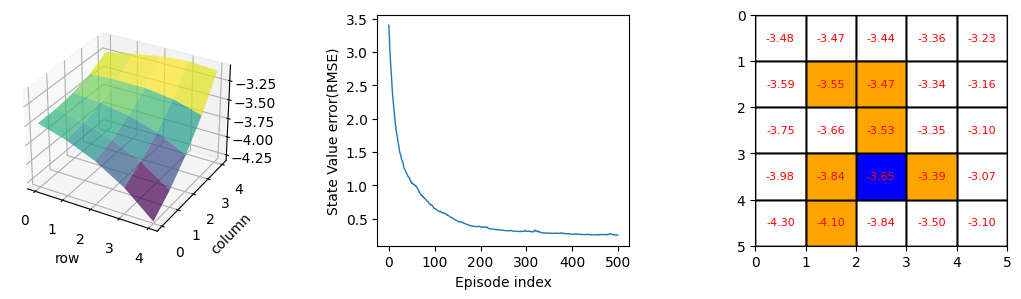

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
m, n = v.shape

# 生成x坐标数组，假设列索引对应的x坐标均匀分布，这里以简单的线性间隔为例
x = np.arange(0, n)

# 生成y坐标数组，同理假设行索引对应的y坐标均匀分布
y = np.arange(0, m)


# 使用meshgrid生成用于绘图的二维坐标网格
X, Y = np.meshgrid(x, y)

# 创建图形对象
# fig = plt.figure()
fig = plt.figure(figsize=(13, 3)) 
# 添加3D子图
ax1 = fig.add_subplot(131, projection='3d')  # 1行2列的第一个
ax1.plot_surface(Y, X, v, cmap='viridis', alpha=0.7)
ax1.set_xlabel('row')
ax1.set_ylabel('column')
plt.subplots_adjust(wspace=0.5)
# 添加第二个子图
ax2 = fig.add_subplot(132)  # 1行2列的第二个
x_axis = [i for i in range(episode_num)]
ax2.plot(x_axis, rmse_list, linewidth=1)
ax2.set_xlabel('Episode index')
ax2.set_ylabel('State Value error(RMSE)')



ax=fig.add_subplot(133)
grid_size = 5

# 定义每个方格的大小
cell_size = 1


# 绘制网格
for i in range(grid_size):
    for j in range(grid_size):
        # 创建一个矩形
        rect = patches.Rectangle((j, i), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='white')
        # 将矩形添加到坐标轴
        ax.add_patch(rect)

# 设置坐标轴的范围
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
rect = patches.Rectangle((2,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='blue')
ax.add_patch(rect)

rect = patches.Rectangle((1,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((2,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((2,2), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((1,4), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((1,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((3,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)


for i in range(grid_size):
    for j in range(grid_size):
        # 创建一个矩形
        rect = patches.Rectangle((j, i), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='none')
        # 将矩形添加到坐标轴
        ax.add_patch(rect)

        # 在方格中心添加对应的数值
        value = v[i][j]
        center_x = j + cell_size / 2
        center_y = i + cell_size / 2
        ax.text(center_x, center_y, f"{value:.2f}", ha='center', va='center', fontsize=8,color='red')

ax.invert_yaxis()
plt.subplots_adjust(wspace=0.5)
# 显示图形
plt.show()

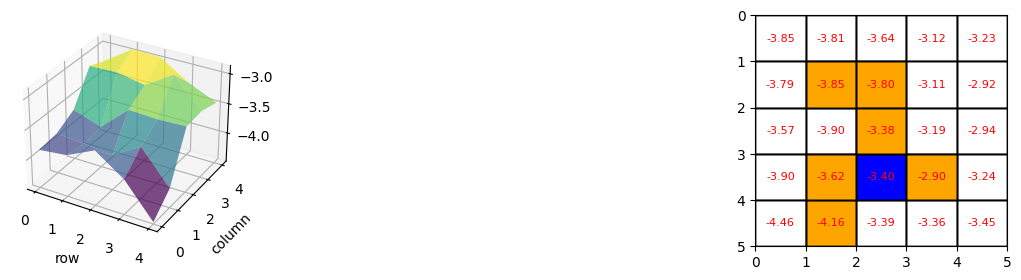

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
m, n = v.shape

# 生成x坐标数组，假设列索引对应的x坐标均匀分布，这里以简单的线性间隔为例
x = np.arange(0, n)

# 生成y坐标数组，同理假设行索引对应的y坐标均匀分布
y = np.arange(0, m)


# 使用meshgrid生成用于绘图的二维坐标网格
X, Y = np.meshgrid(x, y)

# 创建图形对象
# fig = plt.figure()
fig = plt.figure(figsize=(13, 3)) 
# 添加3D子图
ax1 = fig.add_subplot(131, projection='3d')  # 1行2列的第一个
ax1.plot_surface(Y, X, v_target, cmap='viridis', alpha=0.7)
ax1.set_xlabel('row')
ax1.set_ylabel('column')
plt.subplots_adjust(wspace=0.5)
# 添加第二个子图
# ax2 = fig.add_subplot(132)  # 1行2列的第二个
# x_axis = [i for i in range(episode_num)]
# ax2.plot(x_axis, rmse_list, linewidth=1)
# ax2.set_xlabel('Episode index')
# ax2.set_ylabel('State Value error(RMSE)')



ax=fig.add_subplot(133)
grid_size = 5

# 定义每个方格的大小
cell_size = 1


# 绘制网格
for i in range(grid_size):
    for j in range(grid_size):
        # 创建一个矩形
        rect = patches.Rectangle((j, i), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='white')
        # 将矩形添加到坐标轴
        ax.add_patch(rect)

# 设置坐标轴的范围
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
rect = patches.Rectangle((2,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='blue')
ax.add_patch(rect)

rect = patches.Rectangle((1,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((2,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((2,2), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((1,4), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((1,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((3,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)


for i in range(grid_size):
    for j in range(grid_size):
        # 创建一个矩形
        rect = patches.Rectangle((j, i), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='none')
        # 将矩形添加到坐标轴
        ax.add_patch(rect)

        # 在方格中心添加对应的数值
        value = v_target[i][j]
        center_x = j + cell_size / 2
        center_y = i + cell_size / 2
        ax.text(center_x, center_y, f"{value:.2f}", ha='center', va='center', fontsize=8,color='red')

ax.invert_yaxis()
plt.subplots_adjust(wspace=0.5)
# 显示图形
plt.show()